## U-Net for Image Segmentation
   #### Computer Vision Winter Semester 2020/2021 by Clemens Spielvogel
  
U-Net is a fully-convolutional autoencoder architecture used for semantic segmentation of image data. There are several architectural variations such as the V-Net for segmentation of 3D image data.

In the following example you will see a segmentation of 2D images with seismic information for identifying regions containing salt based on a U-Net architecture.

In [1]:
import numpy as np
import pandas as pd
import os
import random
from random import randint
import math
import cv2

import tensorflow as tf
import keras.backend as K
from keras import Model, optimizers
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, BatchNormalization, Concatenate
from sklearn.preprocessing import Binarizer

import plotly.offline as ply
import plotly.graph_objs as graphs
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Seeding random number generators to obtain reproducible results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
def plot_train_val_performance(accs, show=True):
    """Plot training vs. testing accuracy over all epochs"""
    x = list(accs.keys())     # Number of epoch
    y_train = [i[0] for i in accs.values()]
    y_test = [i[1] for i in accs.values()]

    trace_train = graphs.Scatter(x=x, y=y_train, name="Training", mode="lines+markers",
                                 line=dict(width=4),
                                 marker=dict(symbol="circle",
                                             size=10))
    trace_test = graphs.Scatter(x=x, y=y_test, name="Validation", mode="lines+markers",
                                line=dict(width=4),
                                marker=dict(symbol="circle",
                                            size=10))

    layout = graphs.Layout(title="Training vs. Validation IoU",
                           xaxis={"title": "Epoch"},
                           yaxis={"title": "IoU"})

    fig = graphs.Figure(data=[trace_train, trace_test], layout=layout)
    ply.plot(fig, image_filename="plotly_train_val_iou.html", auto_open=show)
    print("Plot saved as plotly_train_val_iou.html")

In [4]:
def create_unet_model(input_shape):
    input = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(16, (3, 3), activation="relu", padding='same')(input)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.5)(conv1)
    conv1 = Conv2D(16, (3, 3), activation="relu", padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation="relu", padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.5)(conv2)
    conv2 = Conv2D(32, (3, 3), activation="relu", padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation="relu", padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.5)(conv3)
    conv3 = Conv2D(64, (3, 3), activation="relu", padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation="relu", padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(0.5)(conv4)
    conv4 = Conv2D(128, (3, 3), activation="relu", padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation="relu", padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(0.5)(conv5)
    conv5 = Conv2D(256, (3, 3), activation="relu", padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D((2, 2))(conv5)

    # Bottleneck
    bn = Conv2D(256, 3, activation="relu", padding='same')(pool5)
    bn = Conv2D(256, 3, activation="relu", padding='same')(bn)

    # Decoder
    upconv1 = Conv2DTranspose(256, (2, 2), strides=2, activation="relu", padding='same')(bn)
    upconv1 = Concatenate()([upconv1, conv5])
    upconv1 = Conv2D(256, (3, 3), activation="relu", padding='same')(upconv1)
    upconv1 = Dropout(0.5)(upconv1)
    upconv1 = Conv2D(256, (3, 3), activation="relu", padding='same')(upconv1)

    upconv2 = Conv2DTranspose(128, (2, 2), strides=2, activation="relu", padding='same')(upconv1)
    upconv2 = Concatenate()([upconv2, conv4])
    upconv2 = Conv2D(128, (3, 3), activation="relu", padding='same')(upconv2)
    upconv2 = Dropout(0.5)(upconv2)
    upconv2 = Conv2D(128, (3, 3), activation="relu", padding='same')(upconv2)

    upconv3 = Conv2DTranspose(64, (2, 2), strides=2, activation="relu", padding='same')(upconv2)
    upconv3 = Concatenate()([upconv3, conv3])
    upconv3 = Conv2D(64, (3, 3), activation="relu", padding='same')(upconv3)
    upconv3 = Dropout(0.5)(upconv3)
    upconv3 = Conv2D(64, (3, 3), activation="relu", padding='same')(upconv3)

    upconv4 = Conv2DTranspose(32, (2, 2), strides=2, activation="relu", padding='same')(upconv3)
    upconv4 = Concatenate()([upconv4, conv2])
    upconv4 = Conv2D(32, (3, 3), activation="relu", padding='same')(upconv4)
    upconv4 = Dropout(0.5)(upconv4)
    upconv4 = Conv2D(32, (3, 3), activation="relu", padding='same')(upconv4)

    upconv5 = Conv2DTranspose(16, (2, 2), strides=2, activation="relu", padding='same')(upconv4)
    upconv5 = Concatenate()([upconv5, conv1])
    upconv5 = Conv2D(16, (3, 3), activation="relu", padding='same')(upconv5)
    upconv5 = Dropout(0.5)(upconv5)
    upconv5 = Conv2D(16, (3, 3), activation="relu", padding='same')(upconv5)

    output = Conv2D(1, 1, activation='sigmoid')(upconv5)

    return Model(inputs=input, outputs=output)

In [5]:
def iou(y_true, y_pred):
    """IoU keras metric"""
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)

    return K.mean(K.stack(prec), axis=0)

In [6]:
# Set hyperparameters
epochs = 50
batch_size = 32
img_size_target = 128
data_dir = "Seismic_data"

In [7]:
# Define amounts of data to be used in each set, relative to whole data
val_data_ratio = 0.15
test_data_ratio = 0.15

In [8]:
# Get IDs for all samples and randomize order
sample_ids = next(os.walk(os.path.join(data_dir, "images")))[2]

# Randomize sample order
random.shuffle(sample_ids)

In [9]:
# Get number of samples in each set
num_samples = len(sample_ids)
val_data_size = math.floor(num_samples * val_data_ratio)
test_data_size = math.floor(num_samples * test_data_ratio)
train_data_size = num_samples - (val_data_size + test_data_size)

In [10]:
# Split data into training, validation and test set
train_ids = sample_ids[:train_data_size]
val_ids = sample_ids[train_data_size:train_data_size + val_data_size]
test_ids = sample_ids[train_data_size + val_data_size:]

In [11]:
# Load data
train_imgs = np.array([cv2.resize(cv2.imread(os.path.join(data_dir, "images", id), 0), (img_size_target, img_size_target))
                       for id in train_ids])
val_imgs = np.array([cv2.resize(cv2.imread(os.path.join(data_dir, "images", id), 0), (img_size_target, img_size_target))
                     for id in val_ids])
test_imgs = np.array([cv2.resize(cv2.imread(os.path.join(data_dir, "images", id), 0), (img_size_target, img_size_target))
                      for id in test_ids])

train_masks = np.array([cv2.resize(cv2.imread(os.path.join(data_dir, "masks", id), 0), (img_size_target, img_size_target))
                        for id in train_ids])
val_masks = np.array([cv2.resize(cv2.imread(os.path.join(data_dir, "masks", id), 0), (img_size_target, img_size_target))
                      for id in val_ids])
test_masks = np.array([cv2.resize(cv2.imread(os.path.join(data_dir, "masks", id), 0), (img_size_target, img_size_target))
                       for id in test_ids])

In [12]:
# Add color channel to data and normalize
train_imgs = train_imgs.reshape((len(train_imgs), img_size_target, img_size_target, 1)) / 255.
val_imgs = val_imgs.reshape((len(val_imgs), img_size_target, img_size_target, 1)) / 255.
test_imgs = test_imgs.reshape((len(test_imgs), img_size_target, img_size_target, 1)) / 255.

train_masks = train_masks.reshape((len(train_masks), img_size_target, img_size_target, 1)) / 255.
val_masks = val_masks.reshape((len(val_masks), img_size_target, img_size_target, 1)) / 255.
test_masks = test_masks.reshape((len(test_masks), img_size_target, img_size_target, 1)) / 255.

In [13]:
# Simple Augmentation
train_imgs = np.append(train_imgs, [np.fliplr(x) for x in train_imgs], axis=0)
train_masks = np.append(train_masks, [np.fliplr(x) for x in train_masks], axis=0)

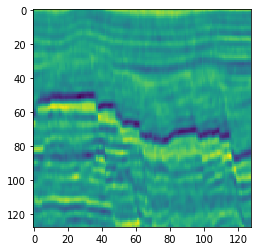

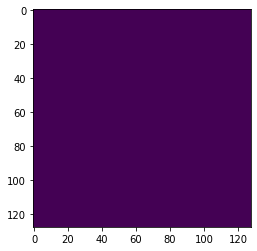

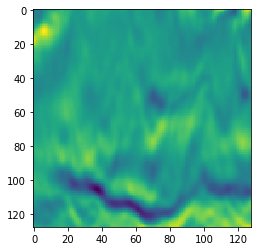

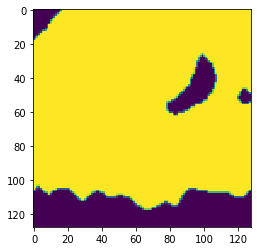

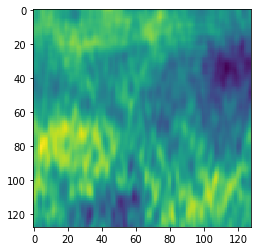

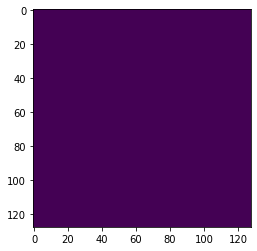

In [14]:
# Display example images
plt.imshow(train_imgs[3].reshape(128, 128))
plt.show()

plt.imshow(train_masks[3].reshape(128, 128))
plt.show()

plt.imshow(train_imgs[4].reshape(128, 128))
plt.show()

plt.imshow(train_masks[4].reshape(128, 128))
plt.show()

plt.imshow(train_imgs[2].reshape(128, 128))
plt.show()

plt.imshow(train_masks[2].reshape(128, 128))
plt.show()

In [15]:
# Setup model
model = create_unet_model((img_size_target, img_size_target, 1))
model.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

In [16]:
# Stopping criterion via early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=4)

# Training
train_summary = model.fit(train_imgs, train_masks,
                    validation_data=[val_imgs, val_masks],
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[callback])

Train on 5600 samples, validate on 600 samples
Epoch 1/50
5600/5600 [==============================] - 61s 11ms/step - loss: 0.4304 - mean_io_u: 0.3763 - val_loss: 0.9762 - val_mean_io_u: 0.3770
Epoch 2/50
5600/5600 [==============================] - 55s 10ms/step - loss: 0.3171 - mean_io_u: 0.3768 - val_loss: 1.5413 - val_mean_io_u: 0.3771
Epoch 3/50
5600/5600 [==============================] - 55s 10ms/step - loss: 0.2788 - mean_io_u: 0.3770 - val_loss: 0.8125 - val_mean_io_u: 0.3771
Epoch 4/50
5600/5600 [==============================] - 55s 10ms/step - loss: 0.2583 - mean_io_u: 0.3770 - val_loss: 0.4102 - val_mean_io_u: 0.3771
Epoch 5/50
5600/5600 [==============================] - 55s 10ms/step - loss: 0.2442 - mean_io_u: 0.3773 - val_loss: 0.2975 - val_mean_io_u: 0.3772
Epoch 6/50
5600/5600 [==============================] - 55s 10ms/step - loss: 0.2344 - mean_io_u: 0.3771 - val_loss: 0.4976 - val_mean_io_u: 0.3772
Epoch 7/50
5600/5600 [==============================] - 55s 10ms/

In [17]:
# Evaluation
loss, mean_iou = model.evaluate(test_imgs, test_masks)
print("Test IoU:", round(mean_iou, 3))
print("Test DICE coefficient:", round((2 * mean_iou) / (1 + mean_iou), 3))

600/600 [==============================] - 2s 3ms/step
Test IoU: 0.383
Test DICE coefficient: 0.554


In [21]:
# Get epochwise performances
train_iou = train_summary.history["mean_io_u"]
val_iou = train_summary.history["val_mean_io_u"]

# Format and store performances per epoch for plotting
performance = {epoch: [round(performance[0], 2), round(performance[1], 2)]
               for epoch, performance in enumerate(zip(train_iou, val_iou))}

# Visualization of epochwise performance
plot_train_val_performance(performance)

Plot saved as plotly_train_val_iou.html


In [22]:
# Format and store performances per epoch for plotting
performance = {epoch: [round(performance[0], 2), round(performance[1], 2)]
               for epoch, performance in enumerate(zip(train_iou, val_iou))}

In [23]:
# Prediction for plotting
pred = model.predict(test_imgs)

In [24]:
# Reshaping images for plotting
test_imgs_plotting = test_imgs.reshape((len(test_imgs), 128, 128))
test_masks_plotting = test_masks.reshape(len(test_masks), 128, 128)
pred_plotting = pred.reshape((len(pred), 128, 128))

In [25]:
# Threshold and dichotomize predictions to yield binary masks
pred_binary = []
for prediction in pred_plotting:  
    transformer = Binarizer(threshold=0.5).fit(prediction)
    pred_binary.append(transformer.transform(prediction))
    
pred_binary = np.array(pred_binary)

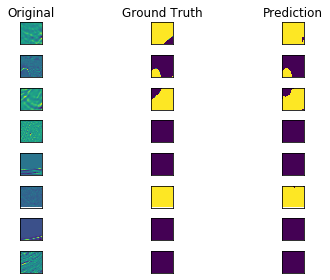

In [26]:
# Visualizing some samples with segmentation
num_samples = 8
shift = 0 # To plot other samples
fig, ax = plt.subplots(num_samples, 3)
params = {"top": False, "bottom": False, "left": False, "right": False, "labelleft": False,
          "labelbottom": False}

ax[0, 0].title.set_text("Original")
ax[0, 1].title.set_text("Ground Truth")
ax[0, 2].title.set_text("Prediction")

for i in range(0, num_samples):
    ax[i, 0].imshow(test_imgs_plotting[i+shift])
    ax[i, 0].tick_params(**params)
    ax[i, 1].imshow(test_masks_plotting[i+shift])
    ax[i, 1].tick_params(**params)
    ax[i, 2].imshow(pred_binary[i+shift])
    ax[i, 2].tick_params(**params)

plt.tight_layout()
plt.show()